In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gaussian_kde
from pathlib import Path
from lib.utils import get_phi_psi_dist, find_kdepeak, find_kdepeak_af, calc_da
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

# When computing da, which cluster is chosen based on:
a. Most Likely
b. X-Ray
c. AlphaFold

- If not most likely, is it usually second most likely?

In [ ]:
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from collections import defaultdict
bw_method = None
chosen_cluster = []
winsizes = [4, 5, 6, 7]
for protein in tqdm(proteins):
    da = DihedralAdherence(protein, winsizes, PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='kde_af')
    da.load_results()
    chosen_clusteri = defaultdict(list)
    print(len(da.xray_phi_psi))

    for seq in da.seqs:
        print(protein, seq)
        phi_psi_dist,info = get_phi_psi_dist(da.queries, seq)
        af = da.phi_psi_predictions[(da.phi_psi_predictions.protein_id == da.alphafold_id) & (da.phi_psi_predictions.seq_ctxt == seq)]
        xray = da.xray_phi_psi[da.xray_phi_psi.seq_ctxt == seq]
        if af.shape[0] == 0 or xray.shape[0] == 0:    
            print(f'Skipping {seq}')
            continue
        xray = xray[['phi', 'psi']].values[0]
        af = af[['phi', 'psi']].values[0]
        print(phi_psi_dist.shape)
        
        phi_psi_dist = phi_psi_dist.loc[~phi_psi_dist[['phi', 'psi']].isna().any(axis=1)]
        if phi_psi_dist.shape[0] < 4:
            print(f'Skipping {seq}')
            continue
        try:

            # kde for entire dist:
            entire_kde = gaussian_kde(
                phi_psi_dist[['phi','psi']].T, 
                weights=phi_psi_dist['weight'], 
                bw_method=bw_method
            )
            # phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-180, 180, 360))
            # grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
            # probs = entire_kde(grid).reshape(phi_grid.shape)
            # kdepeak = grid[:,probs.argmax()]
            # print('ENTIRE', kdepeak, probs.max())

            bandwidth = 100
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
            ms.fit(phi_psi_dist[['phi','psi']])
            phi_psi_dist['cluster'] = ms.labels_

            cluster_counts = phi_psi_dist.groupby('cluster').size()
            phi_psi_dist['cluster'] = phi_psi_dist['cluster'].apply(lambda x: x if cluster_counts[x] > 4 else -1)


            cluster_peaks = []
            probs = []
            for i in phi_psi_dist.cluster.unique():
                if i == -1:
                    continue
                kdepeak_c,prob = find_kdepeak(phi_psi_dist[phi_psi_dist.cluster == i], bw_method, return_prob=True)
                # print(f'CLUSTER LOCAL {i}', kdepeak_c.values, prob)
                probs.append(prob)
                cluster_peaks.append(kdepeak_c.values)

                peak_prob = entire_kde(kdepeak_c.values)
                # print(f'CLUSTER {i}:', kdepeak_c.values, peak_prob)
            cluster_peaks = np.array(cluster_peaks)[np.argsort(probs)][::-1]
            probs = np.sort(probs)[::-1]
            # print(probs)
            # print(cluster_peaks)

            print(f'\tFound {len(cluster_peaks)} Clusters')

            # Choose peak that is closest to AlphaFold prediction
            dists = calc_da(af, cluster_peaks)
            af_argmin = dists.argmin()
            af_probs_ratio = probs[af_argmin]/probs[0]
            
            # Choose peak that is closest toX-ray prediction
            dists = calc_da(xray, cluster_peaks)
            argmin = dists.argmin()
            xray_probs_ratio = probs[argmin]/probs[0]

            chosen_clusteri['af'].append(af_argmin)
            chosen_clusteri['af_prob'].append(probs[af_argmin])
            chosen_clusteri['af_prob_ratio'].append(af_probs_ratio)

            chosen_clusteri['xray'].append(argmin)
            chosen_clusteri['xray_prob'].append(probs[argmin])
            chosen_clusteri['xray_prob_ratio'].append(xray_probs_ratio)

            # Choose peak that would be PDBMine prediction - highest prob
            chosen_clusteri['pdbmine'].append(0)
            chosen_clusteri['pdbmine_prob'].append(probs[0])
            chosen_clusteri['pdbmine_prob_ratio'].append(1)
        except Exception as e:
            print(e)
            continue
        chosen_clusteri['seq'].append(seq)
        n_samples = phi_psi_dist.groupby('winsize').size().to_dict()
        for w in winsizes:
            if not w in n_samples:
                n_samples[w] = 0
        chosen_clusteri['n_samples_w'].append(n_samples)
        chosen_clusteri['n_samples'].append(sum(list(n_samples.values())))
    chosen_cluster.append(pd.DataFrame(chosen_clusteri).assign(protein=protein))
    break
chosen_cluster = pd.concat(chosen_cluster)
chosen_cluster.to_csv('cluster_choice.csv', index=False)

In [3]:
chosen_cluster = pd.read_csv('cluster_choice.csv')

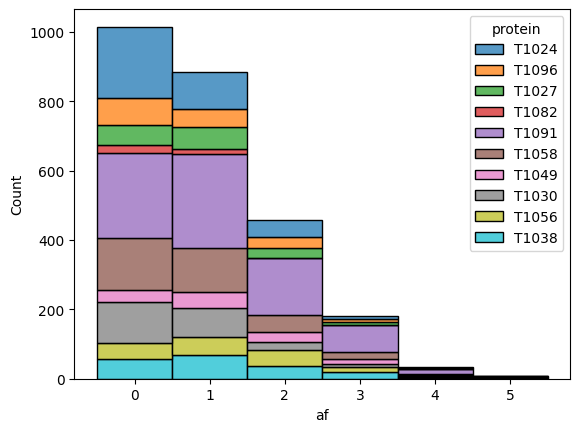

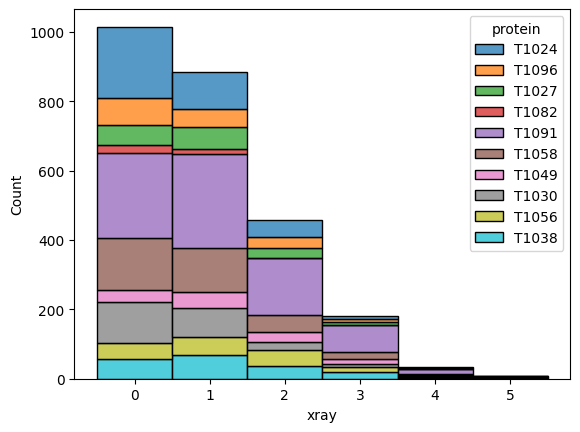

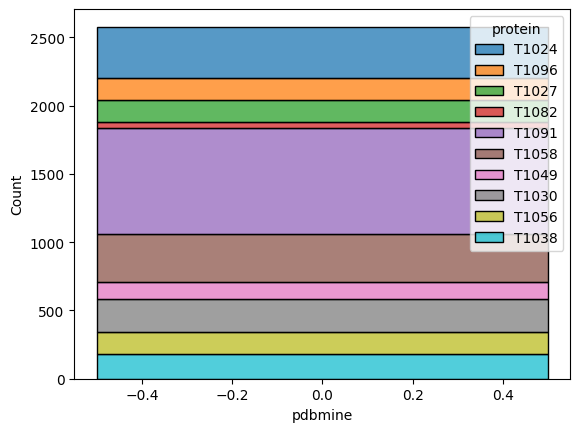

In [4]:
chosen_cluster['af'] = chosen_cluster.af.astype(int)
chosen_cluster['xray'] = chosen_cluster.xray.astype(int)
chosen_cluster['pdbmine'] = chosen_cluster.pdbmine.astype(int)
sns.histplot(data=chosen_cluster, x='af', discrete=True, hue='protein', multiple='stack')
plt.show()
sns.histplot(data=chosen_cluster, x='xray', discrete=True, hue='protein', multiple='stack')
plt.show()
sns.histplot(data=chosen_cluster, x='pdbmine', discrete=True, hue='protein', multiple='stack')
plt.show()

Text(0, 0.5, 'Average Probability')

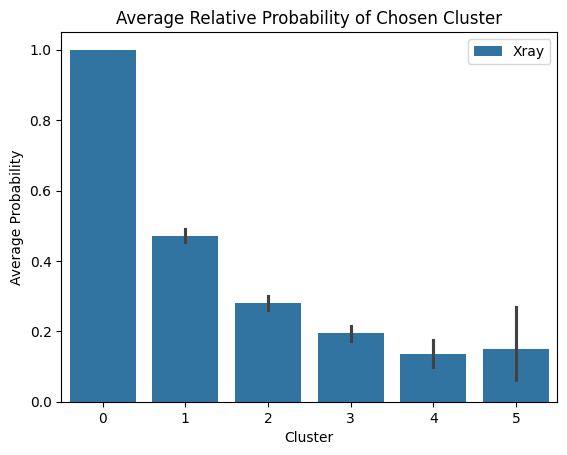

In [88]:
# grouped = chosen_cluster.groupby('xray').agg(xray_prob=('xray_prob', lambda x: -np.sum(np.log(x))))
fig, ax = plt.subplots()
sns.barplot(chosen_cluster, x='xray', y='xray_prob_ratio', ax=ax, label='Xray')

# grouped = chosen_cluster.groupby('xray').agg(xray_prob=('xray_prob', lambda x: -np.sum(np.log(x))))
# grouped = chosen_cluster.groupby('af').mean(numeric_only=True)
# sns.barplot(grouped, x='af', y='af_prob', ax=ax, alpha=0.5, label='AlphaFold')
ax.set_title('Average Relative Probability of Chosen Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Average Probability')

# on average, when the second most probable cluster is chosen, it is half as probable as the peak cluster

In [95]:
filtered = chosen_cluster.copy()
for i in range(4):
    filtered[f'{i+4}'] = filtered.n_samples_w.apply(lambda x: eval(x)[i+4])
    filtered = filtered[filtered[f'{i+4}'] < filtered[f'{i+4}'].quantile(1)]

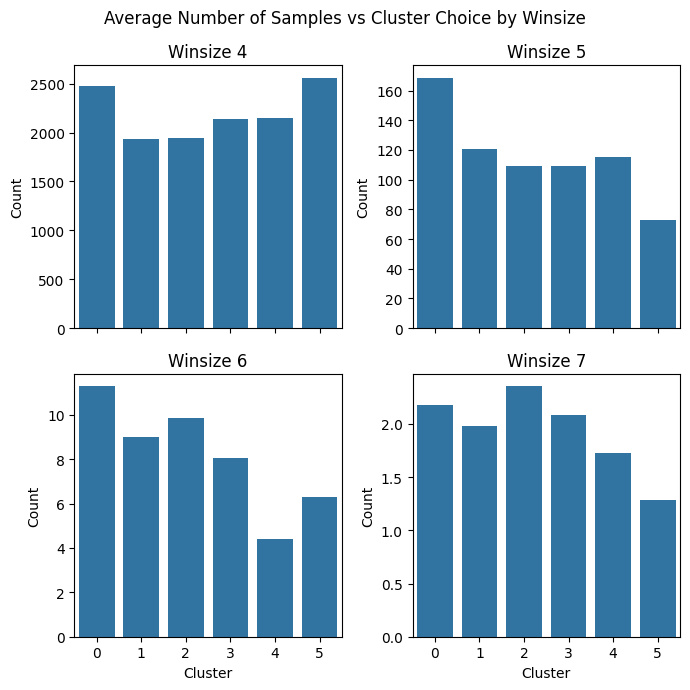

In [96]:
# grouped = filtered[['xray',*[f'{i+4}' for i in range(4)]]].melt(id_vars='xray', var_name='winsize', value_name='n_samples')
fig, axes = plt.subplots(2, 2, figsize=(7,7), sharex=True)
for i, ax in enumerate(axes.flatten()):
    sns.barplot(filtered, x='xray', y=f'{i+4}', ax=ax, errorbar=None)
    ax.set_title(f'Winsize {i+4}')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
fig.suptitle('Average Number of Samples vs Cluster Choice by Winsize')
plt.tight_layout()